In [1]:
# The purpose of this file is to use logistic regression to predict the SIDD and NON-SIDD groups 
# created by Zhongyu Li, May 2024 
# Note: we will only use 6 cohort with HOMA2IR and HOMA2B data

In [3]:
# load libraries
import pandas as pd 
import numpy as np
import os as os

import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression



In [6]:
os. getlogin()

'root'

In [ ]:
#not working, need to figure out why as of 5.18.24 

os. getlogin()

if os.getlogin()=="JVARGH7":
    path_folder = 'C:/Cloud/Emory University/li, zhongyu - Diabetes Endotypes Project (JV and ZL)'
if os.getlogin()=="zhongyuli":
    path_folder = '/Users/zhongyuli/Library/CloudStorage/OneDrive-EmoryUniversity/Diabetes Endotypes Project (JV and ZL)'

# Rename the dataset into analytic sample
analytic_dataset = pd.read_csv(path_folder + '/working/processed/final_dataset.csv')


In [4]:
# first, we will load the data and conduct k means clustering to create the "TRUE labels"
# we will use the HOMA2IR and HOMA2B data to create the labels
# we will use the first 6 cohorts


path = '/Users/zhongyuli/Desktop/python/cluster analysis/dataset/final_dataset.csv'

analytic_dataset = pd.read_csv(path) 

#drop missing values
method3_df = analytic_dataset[analytic_dataset['method3'] == 1]

#select variables 
selected_variables = ['bmi', 'hba1c', 'dmagediag','homa2b','homa2ir','tgl','ldlc','ratio_th','sbp','dbp','hdlc','study']

#drop missing values in the selected variables
method3_df = method3_df[selected_variables]
method3_df = method3_df.dropna()

#check the data
method3_df.head()



,bmi,hba1c,dmagediag,homa2b,homa2ir,tgl,ldlc,ratio_th,sbp,dbp,hdlc,study
0,33.37665,6.9,70.0,102.7,2.217295,124,83.0,3.179487,119.2454,65.9166,39.0,jhs
1,27.76165,6.5,68.0,113.6,1.945525,101,81.0,1.980392,119.2454,65.0865,51.0,jhs
2,30.73822,7.9,51.0,40.6,2.192982,117,131.0,3.342857,162.3397,99.1206,35.0,jhs
3,43.56290,6.9,65.0,99.9,2.469136,78,97.0,1.322034,130.2482,70.0671,59.0,jhs
4,29.33333,6.5,77.0,104.9,2.577320,158,112.0,2.724138,121.0792,64.2564,58.0,jhs


In [5]:
#take out the "study" variable
study = method3_df['study']
method3_df = method3_df.drop(columns = ['study']) 

method3_df.shape

(3771, 11)

In [6]:
# check if there are any missing values
method3_df.isnull().sum()
# check variable types
method3_df.dtypes



bmi          float64
hba1c        float64
dmagediag    float64
homa2b       float64
homa2ir      float64
tgl            int64
ldlc         float64
ratio_th     float64
sbp          float64
dbp          float64
hdlc         float64
dtype: object

In [7]:
#run kmeans clustering to create the TRUE labels
#standardize the data
scaler = StandardScaler()
method3_df_scaled = scaler.fit_transform(method3_df)

method3_df_scaled = pd.DataFrame(method3_df_scaled, columns=method3_df.columns)



In [8]:
method3_df_scaled.head()

,bmi,hba1c,dmagediag,homa2b,homa2ir,tgl,ldlc,ratio_th,sbp,dbp,hdlc
0,-0.032257,0.300357,0.645757,-0.220785,-0.458673,-0.242366,-0.774925,-0.090932,-0.326612,-0.636184,-0.668157
1,-0.832829,-0.048265,0.489212,-0.091397,-0.560173,-0.512939,-0.830633,-0.511314,-0.326612,-0.692720,0.252415
2,-0.408438,1.171911,-0.841426,-0.957942,-0.467753,-0.324714,0.562068,-0.033657,1.987405,1.625245,-0.975014
3,1.420073,0.300357,0.254393,-0.254023,-0.364617,-0.783512,-0.384969,-0.742123,0.264201,-0.353505,0.866129
4,-0.608743,-0.048265,1.193667,-0.194670,-0.324213,0.157612,0.032841,-0.250570,-0.228143,-0.749256,0.789414


In [9]:
# run kmeans and get cluster labels from the five variable method (method 3)
kmeans = KMeans(
    init="random", n_clusters=4, n_init=10, max_iter=300, random_state=57
)

# select five variables to cluster
var_m3 = ['bmi', 'hba1c', 'dmagediag','homa2b','homa2ir']
cluster_m3 = method3_df_scaled[var_m3]

kmeans = KMeans(init="random", n_clusters=4, n_init=10, max_iter=300, random_state=57)
kmeans.fit(cluster_m3)

KMeans(init='random', n_clusters=4, n_init=10, random_state=57)

In [12]:
# summarize the cluster labels 
method3_df_cluster = method3_df
method3_df_cluster['cluster'] = kmeans.labels_
method3_df_cluster['cluster'].value_counts()


cluster
0    1766
1    1481
3     290
2     234
Name: count, dtype: int64

In [13]:
#summarize variables by cluster
method3_df_cluster.groupby('cluster').mean()

,bmi,hba1c,dmagediag,homa2b,homa2ir,tgl,ldlc,ratio_th,sbp,dbp,hdlc
cluster,,,,,,,,,,,
0,29.624151,6.269762,70.743322,86.821631,2.107629,133.261608,106.051076,2.960120,127.687002,70.621010,50.251076
1,38.086894,6.384085,51.314338,133.598042,3.866042,155.496286,117.407562,3.903651,122.223853,80.640832,44.889804
2,34.958178,9.900000,55.524927,52.536325,3.077110,149.948718,116.474359,3.587225,126.418088,80.898582,47.239316
3,33.839130,6.470690,65.299499,323.935517,9.741132,153.713793,101.668966,3.860884,125.934720,71.448641,47.013793


In [14]:
# remane the cluster labels
method3_df_cluster['cluster'] = method3_df_cluster['cluster'].replace({0: 'MARD', 1: 'MOD', 2: 'SIDD', 3: 'SIRD'})
method3_df_cluster['cluster'].value_counts()


cluster
MARD    1766
MOD     1481
SIRD     290
SIDD     234
Name: count, dtype: int64

In [15]:
#summarize variables by cluster
method3_df_cluster.groupby('cluster').mean()

,bmi,hba1c,dmagediag,homa2b,homa2ir,tgl,ldlc,ratio_th,sbp,dbp,hdlc
cluster,,,,,,,,,,,
MARD,29.624151,6.269762,70.743322,86.821631,2.107629,133.261608,106.051076,2.960120,127.687002,70.621010,50.251076
MOD,38.086894,6.384085,51.314338,133.598042,3.866042,155.496286,117.407562,3.903651,122.223853,80.640832,44.889804
SIDD,34.958178,9.900000,55.524927,52.536325,3.077110,149.948718,116.474359,3.587225,126.418088,80.898582,47.239316
SIRD,33.839130,6.470690,65.299499,323.935517,9.741132,153.713793,101.668966,3.860884,125.934720,71.448641,47.013793


### NOW we will create SIDD and nonSIDD group from the k means cluster (five variable method)

In [17]:
# Aggregate MARD, MOD, and SIRD in to non-SIDD group
method_lr = method3_df_cluster.copy()
method_lr['cluster'] = method_lr['cluster'].replace({'MARD': 'NON-SIDD', 'MOD': 'NON-SIDD', 'SIRD': 'NON-SIDD'})
method_lr['cluster'].value_counts()


cluster
NON-SIDD    3537
SIDD         234
Name: count, dtype: int64

In [35]:
# now run logistic regression to predict the SIDD and NON-SIDD groups using nine variables
# select variables
var_lr = ['bmi', 'hba1c', 'dmagediag','tgl','ldlc','ratio_th','sbp','dbp','hdlc']
X = method_lr[var_lr]
y = method_lr['cluster'].map({'NON-SIDD': 0, 'SIDD': 1}) 

model = LogisticRegression(max_iter=1000, random_state=57)
# Evaluate the model using 5-fold cross-validation
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=57)
cv_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

# Print cross-validation scores
print(f'Cross-validation scores: {cv_scores}')
print(f'Mean cross-validation score: {cv_scores.mean()}')

# Fit the model using the entire dataset to obtain the coefficients
model.fit(X, y)

# Obtain the coefficients
coefficients = model.coef_[0]
intercept = model.intercept_[0]

# Create a DataFrame to display the coefficients
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

print("Model Coefficients:")
print(coef_df)
print(f"Intercept: {intercept}")

# save the coefficients to a csv file
path_folder = '/Users/zhongyuli/Library/CloudStorage/OneDrive-EmoryUniversity/Diabetes Endotypes Project (JV and ZL)'
coef_df.to_csv(path_folder + '/working/processed/logistic_regression_coefficients_SIDD_non_SIDD.csv', index=False)


Cross-validation scores: [0.98278146 0.98806366 0.99071618 0.98938992 0.98541114]
Mean cross-validation score: 0.9872724717620812
Model Coefficients:
     Feature  Coefficient
0        bmi    -0.010282
1      hba1c     4.260511
2  dmagediag    -0.051681
3        tgl     0.005170
4       ldlc    -0.004628
5   ratio_th    -0.187948
6        sbp    -0.002069
7        dbp     0.008289
8       hdlc     0.012713
Intercept: -32.7843869390105


##### 

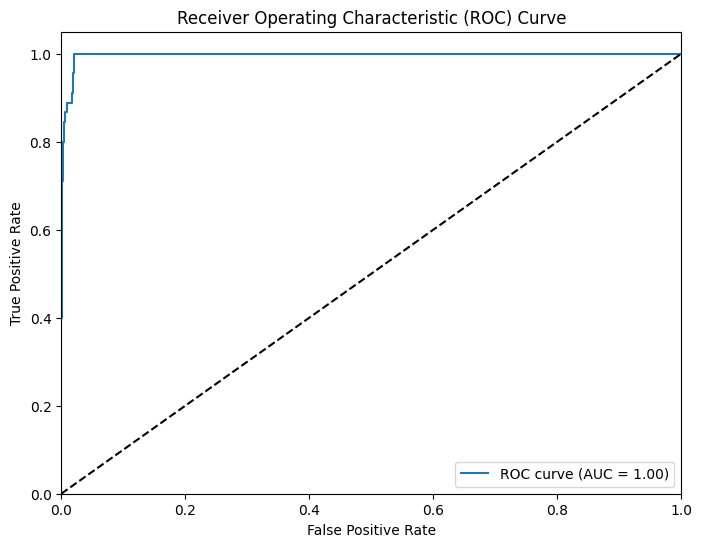

In [38]:
#create the ROC-AUC curve
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# from sklearn.metrics import plot_roc_curve


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=57)

# Fit the model on the training data
model.fit(X_train, y_train)

# Predict probabilities for the test set
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the AUC score
auc_score = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()




#### Some other codes to produce P values and 95%CI 

In [31]:
# obtain the p values 
from scipy.stats import chi2
from scipy.stats import chi2_contingency

# calculate the p values
p_values = []
for feature in X.columns:
    # Create a contingency table
    contingency_table = pd.crosstab(method_lr['cluster'], method_lr[feature])
    # Perform the chi-squared test
    chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
    p_values.append(p_val)

# Add the p-values to the DataFrame
coef_df['p_value'] = p_values

# Display the coefficients and p-values
print(coef_df)


     Feature  Coefficient       p_value
0        bmi    -0.010282  6.267334e-01
1      hba1c     4.260511  0.000000e+00
2  dmagediag    -0.051681  1.000000e+00
3        tgl     0.005170  4.426286e-02
4       ldlc    -0.004628  3.144571e-01
5   ratio_th    -0.187948  5.273901e-03
6        sbp    -0.002069  1.844788e-27
7        dbp     0.008289  3.392343e-17
8       hdlc     0.012713  9.999864e-01


In [36]:
from sklearn.metrics import classification_report

model = LogisticRegression(max_iter=1000)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=57)

for train_index, test_index in cv.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(classification_report(y_test, y_pred))



              precision    recall  f1-score   support

           0       0.99      1.00      0.99       708
           1       0.93      0.79      0.85        47

    accuracy                           0.98       755
   macro avg       0.96      0.89      0.92       755
weighted avg       0.98      0.98      0.98       755

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       708
           1       0.91      0.89      0.90        46

    accuracy                           0.99       754
   macro avg       0.95      0.94      0.95       754
weighted avg       0.99      0.99      0.99       754

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       707
           1       0.98      0.87      0.92        47

    accuracy                           0.99       754
   macro avg       0.98      0.94      0.96       754
weighted avg       0.99      0.99      0.99       754

              preci